In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import iBioGen

from collections import Counter
from itertools import combinations
from scipy.stats import entropy

import sys
sys.path.append('/home/isaac/proj/IMEMEBA-BCI')
import BCI

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
#ipyclient = ipp.Client(cluster_id="iBioGen")
#len(ipyclient)

### Metadata explanations
The metadata has one row for each OTU for **every** `sample_id` whether it is present or not, so you have to prune everything that doesn't have `abundance` > 0.
* size-  the samples were sorted based on size: xs (0-2 mm), s (2-4 mm), m (4-6 mm),  L  (7+ mm)
* count- # of individuals counted at that size
* farm_forest- whether the site is a farm or a forest
* farm_type- whether the farm has been deemed "simplified" (i.e., monoculture (1-2 crops)) or "diversified"  (i.e.,  3+ crops)
* crop_diversity- number of different crop species recorded through a crop survey 
* Noncrop_diversity: number of non-crop species surveyed.
* Polynesian_crops: number of surveyed crops that can be classified as Polynesian in origin. 
* n_sampled- number of different crops actually sampled
* size_acres- the size of a farm site 
* disnatural_habitat- the distance of a farm from the nearest forest edge 
* predict- the NIclassify prediction of whether the OTU is native or introduced
* **Abundance- read abundance**

In [2]:
metadata = pd.read_csv("MESSupdated.csv", low_memory=False)
#Counter(metadata.iloc[:, 13])
# Not sure why all the duplicate lines, but remove them
metadata = metadata.drop_duplicates()
# Only retain rows with OTU abundance > 0
metadata = metadata[metadata["abundance"] > 0]
metadata

,site,transect,plant,size,count,sample_id,farm_forest,site_type,elevation,precepitation_mm,size_acres,crop_diversity,n_sampled,noncrop_diversity,polynesian_crops,disnatural_meters,OTU,order,family,genus,species,trophic,invasive_pest,predict,abundance,farm_type
10,KE,1R,coffee,xs,53,KE1R253,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU9,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,10,diversified
543,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU7,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,150,diversified
544,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU7,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,46,diversified
545,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU7,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,3,diversified
546,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU8,Hymenoptera,Formicidae,Technomyrmex,Technomyrmex albipes,predator,TRUE,introduced,21363,diversified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217697,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU142,Diptera,NaN,NaN,NaN,parasite,NaN,introduced,117,simplified
217757,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU249,Isopoda,NaN,NaN,NaN,NaN,NaN,introduced,231,simplified
217773,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU264,Isopoda,NaN,NaN,NaN,NaN,NaN,introduced,84,simplified
217817,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU354,Isopoda,NaN,NaN,NaN,NaN,NaN,introduced,5,simplified


## Make a dict mapping OTU names to sequences

In [3]:
fasta_data = open("Leke_MESS.fasta").read().split()
otu_dict = {}
for line in fasta_data:
    if ">" in line:
        otu = line.split("_")[0].strip(">")
        otu_dict[otu] = ""
    else:
        otu_dict[otu] = otu_dict[otu] + line

In [ ]:
## Make a new fasta file for all the sequences w/in a site

In [22]:
# A dictionary mapping 'site' to a site-type for improved plotting
# We'll give the fasta files the long form names so that BCI will pick them up
site_dict = {"KE":'diversified-KE',
             "JO":'simplified-JO',
             "JE":'simplified-JE',
             "MN":'forest-MN',
             "CO":'diversified-CO',
             "MK":'forest-MK',
             "TK":'simplified-TK',
             "NO":'diversified-NO'
            }

for site, otus in metadata.groupby("site")["OTU"]:
    print(site, len(set(otus.values)))
    with open(f"otu_site_fastas/{site_dict[site]}.fasta", 'w') as outfile:
        for otu in set(otus):
            outfile.write(f">{otu}\n{otu_dict[otu]}\n")

# Split native and introduced into separate files as well
for i in ["native", "introduced"]:
    tmp = metadata[metadata["predict"] == i]

    for site, otus in tmp.groupby("site")["OTU"]:
        with open(f"otu_{i}_fastas/{site_dict[site]}.fasta", 'w') as outfile:
            for otu in set(otus):
                 outfile.write(f">{otu}\n{otu_dict[otu]}\n")


CO 84
JE 60
JO 104
KE 101
MK 61
MN 78
NO 101
TK 48


In [20]:


fastas = sorted(glob.glob("otu_site_fastas/*.fasta"))
bcis = {}
for fasta in fastas:
    site = fasta.split("/")[1].split(".")[0]
    print(site)
    bcis[site] = BCI.BCI(data=fasta)
    bcis[site]._min_clust_threshold = 70
    bcis[site].run()

diversified-CO
diversified-KE
diversified-NO
forest-MK
forest-MN
simplified-JE
simplified-JO
simplified-TK


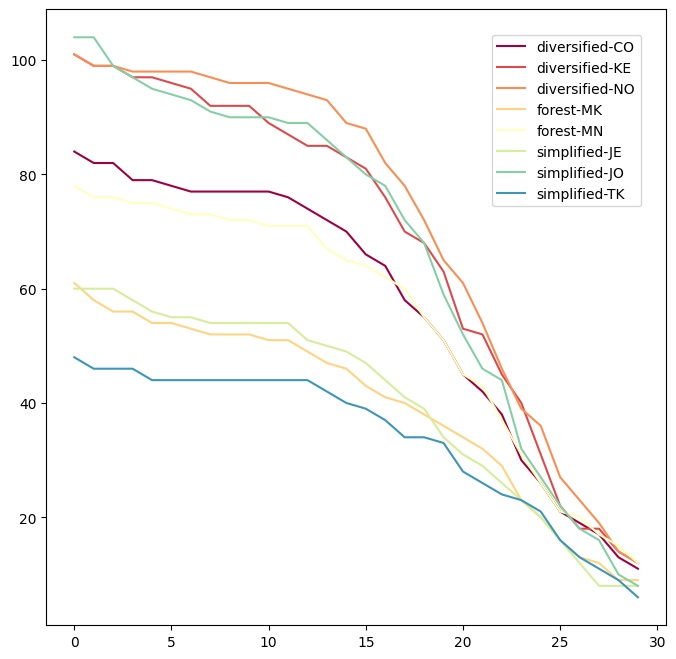

In [21]:
_ = BCI.plot_multi(bcis.values(), log=False, normalize=False, cmap="Spectral")

In [23]:
fastas = sorted(glob.glob("otu_native_fastas/*.fasta"))
native_bcis = {}
for fasta in fastas:
    site = fasta.split("/")[1].split(".")[0]
    print(site)
    native_bcis[site] = BCI.BCI(data=fasta)
    native_bcis[site]._min_clust_threshold = 70
    native_bcis[site].run()

fastas = sorted(glob.glob("otu_introduced_fastas/*.fasta"))
introduced_bcis = {}
for fasta in fastas:
    site = fasta.split("/")[1].split(".")[0]
    print(site)
    introduced_bcis[site] = BCI.BCI(data=fasta)
    introduced_bcis[site]._min_clust_threshold = 70
    introduced_bcis[site].run()

diversified-CO
diversified-KE
diversified-NO
forest-MK
forest-MN
simplified-JE
simplified-JO
simplified-TK
diversified-CO
diversified-KE
diversified-NO
forest-MK
forest-MN
simplified-JE
simplified-JO
simplified-TK


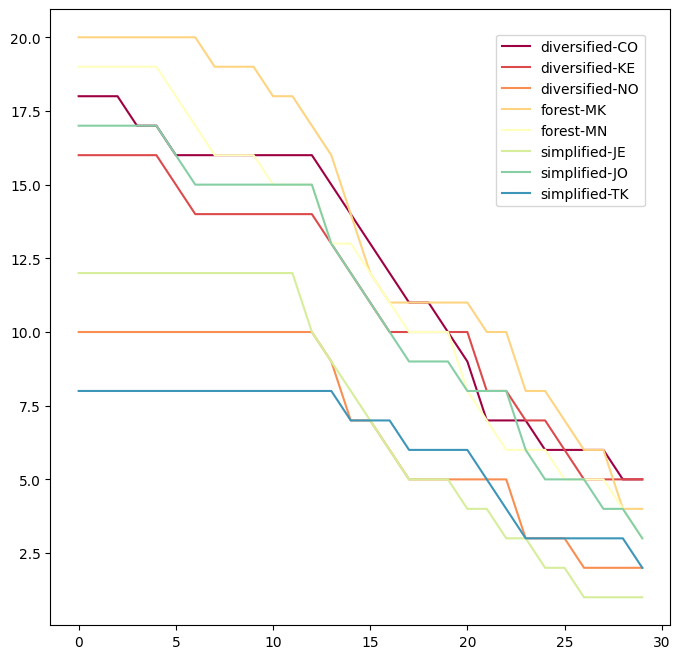

In [24]:
_ = BCI.plot_multi(native_bcis.values(), log=False, normalize=False, cmap="Spectral")

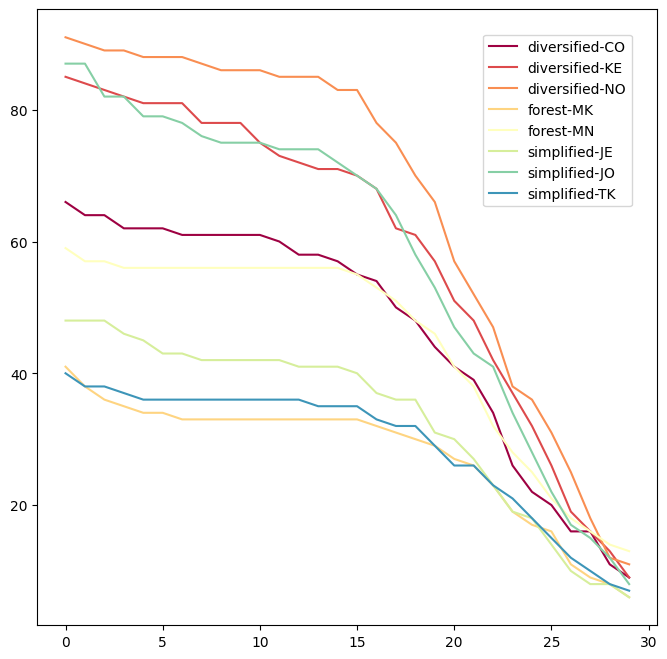

In [127]:
_ = BCI.plot_multi(introduced_bcis.values(), log=False, normalize=False, cmap="Spectral")

## Unused

In [6]:
asvs = pd.read_csv("asv_table2.csv")
#set(asvs["sample_id"])
asvs

Unnamed: 0         sample_id   ASV1  ASV2   ASV3  ASV4  ASV5  ASV6  ASV7  \
0             1  Capriola1CO1L220      5     0      0     0     0     0     0   
1             2  Capriola1CO1L243     45     0      0     0     0     0     0   
2             3  Capriola1CO1L470      0     0      0     0     0     0     0   
3             4   Capriola1CO1L71      0     0      0     0     0     0     0   
4             5  Capriola1CO1R231  21678     0      0    72     0     0     0   
..          ...               ...    ...   ...    ...   ...   ...   ...   ...   
842         843    LeePark3TK5L71    163     0     70     0     0     0     0   
843         844   LeePark3TK5R230   6241     0   1792     0     0     0     0   
844         845  LeePark3TK5R2420   4255     0   9541     0     0     0     0   
845         846   LeePark3TK5R476    159     0  15281     9     0     0     0   
846         847    LeePark3TK5R71      0     8     17     0    31     0     0   

     ASV8  ASV9  ASV10  ASV11  ASV12  ASV13  ASV14  ASV15  ASV16  ASV17  \
0       0     0      0      0      0      0      0      0      0      0   
1      21     0      0      0      0      0      0   1068      0      0   
2       0     0      0      0      0      0      0      0      0      0   
3       0     0      0      0      0      0      0      0      0      0   
4      27     0      0      0   3551      0      0    101      0   3702   
..    ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
842     0     0      0      0      0      0      0      0      0      0   
843     0     0      0    450    676      0      0      0      0    494   
844  5036     0      0      0    480      0      0      0      0      0   
845    11     0      0      0      0      0      0      0      0      0   
846     0     0      0      0      0      0      0      0      0      0   

     ASV18  ASV19  ASV20  ASV21  ASV22  ASV23  ASV24  ASV25  ASV26  ASV27  \
0        0      0      0      0      0      0      0      0      0      0   
1        0      0      0      0      0      0      0      0      0      0   
2        0      0      0      0      0      0      0      0      0      0   
3        0      0      0      0      0      0      0      0      0      0   
4       19      0      0      0      0      0      0      0      0     31   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
842      0      0      0      0      0      0      0      0      0      0   
843      0      0      0      0      0      0      0      0      0      0   
844      0      0      0      0      0      0      0      0      0      0   
845      0      0      0      0      0      0      0      0      0      0   
846      0      0      0      0      0      0      0      0      0      0   

     ASV28  ASV29  ASV30  ASV31  ASV32  ASV33  ASV34  ASV35  ASV36  ASV37  \
0        0      0      0      0      0      0      0      0      0      0   
1        0      0      0      0      0      0     11      0      0      0   
2        0      0      0      0      0      0      0      0      0      0   
3        0      0      0      0      0      0      0      0      0      0   
4        0      0      0      0      0      0      0      0      0      0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
842      0      0      0      0      0      0      0      0      0      0   
843      0      0      0      0      0      0      0      0      0      0   
844      0      0      0      0      0      0    940      0      0      0   
845      0      0      0      6      0      0      4      0      0      0   
846      0      0      0      6      0      0      0      0      0      0   

     ASV38  ASV39  ASV40  ASV41  ASV42  ASV43  ASV44  ASV45  ASV46  ASV47  \
0        0      0      0      0      0      0      0      0      0      0   
1        0      0      0      0      0      0      0      0      0      0   
2        0      0      0      0      0      0     

In [46]:
print(set(metadata["sample_id"]))
co_df = metadata[metadata["site"] == "MN"]
print(len(set(co_df["OTU"])))
co_df

{'NO3L70', 'JE1L70', 'JO4R470', 'JE1L245', 'TK4L470', 'JO5L240', 'MN020', 'CO4L246', 'NO2R211', 'TK3R247', 'MN2L470', 'MK1L472', 'NO4R470', 'TK4L243', 'CO5L239', 'JO5R70', 'KE5R70', 'MK2R270', 'MN4L470', 'TK4R70', 'NO2L216', 'KE1L70', 'MNLL4742', 'CO1R470', 'CO3R470', 'MN070', 'JE1L23', 'CO2R246', 'TK1L214', 'JOLL20', 'NOCF244', 'TK3L472', 'JO1L241', 'MKLL271', 'NO5R70', 'MNLL240', 'MK2R26', 'MN1L241', 'CO2L222', 'CO4R242', 'CO3L70', 'CO1L243', 'KE1R470', 'CO3R223', 'NO3L470', 'JE3L71', 'TK1R240', 'MN4R471', 'JO4L70', 'NO5R470', 'NOLL4712', 'CO4L472', 'KE4R269', 'CO2R70', 'JO2R223', 'JE2L71', 'NO1L70', 'MKLL241', 'MN2L241', 'JO3R70', 'KE1L222', 'JO3L470', 'JOLL2265', 'MN0240', 'JE3L210', 'KE4R471', 'JE2R70', 'MKLL470', 'MN4L70', 'MN3R245', 'MNLL294', 'NO5R220', 'KE3R240', 'COLL715', 'MN4R248', 'NO3L241', 'KE5R2419', 'CO3R70', 'NO1R70', 'NOLL70', 'TK1R70', 'KELL70', 'JE5R74', 'COLL4748', 'COLL292', 'JE4L27', 'JE2R27', 'TK5L472', 'JE5L70', 'JO2L242', 'MK3L29', 'NOCF247', 'KE3L470', 'NO5L

,site,transect,plant,size,count,sample_id,farm_forest,site_type,elevation,precepitation_mm,size_acres,crop_diversity,n_sampled,noncrop_diversity,polynesian_crops,disnatural_meters,OTU,order,family,genus,species,trophic,invasive_pest,predict,abundance,farm_type
26967,MN,4L,kukui,xs,58,MN4L258,forest,forest,2200,857,na,na,5,na,1,0,OTU3,Amphipoda,NaN,NaN,NaN,NaN,NaN,introduced,0,forest
26970,MN,4L,kukui,xs,58,MN4L258,forest,forest,2200,857,na,na,5,na,1,0,OTU5,Lepidoptera,Dryadaulidae,Dryadaula,Dryadaula terpsichorella,detritivore,NaN,introduced,0,forest
26973,MN,4L,kukui,xs,58,MN4L258,forest,forest,2200,857,na,na,5,na,1,0,OTU6,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,193,forest
26974,MN,4L,kukui,xs,58,MN4L258,forest,forest,2200,857,na,na,5,na,1,0,OTU6,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,0,forest
26976,MN,4L,kukui,xs,58,MN4L258,forest,forest,2200,857,na,na,5,na,1,0,OTU7,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,988,forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200245,MN,0,na,lg,0,MN070,forest,forest,2200,857,na,na,5,na,1,0,OTU2161,Trombidiformes,NaN,NaN,NaN,NaN,NaN,introduced,0,forest
200246,MN,0,na,lg,0,MN070,forest,forest,2200,857,na,na,5,na,1,0,OTU2178,Sarcoptiformes,Steganacaridae,Steganacarus,Steganacarus magnus,detritivore,NaN,introduced,0,forest
200247,MN,0,na,lg,0,MN070,forest,forest,2200,857,na,na,5,na,1,0,OTU2180,Hymenoptera,Figitidae,Ganaspis,NaN,parasite,NaN,introduced,0,forest
200248,MN,0,na,lg,0,MN070,forest,forest,2200,857,na,na,5,na,1,0,OTU2189,Mesostigmata,NaN,NaN,NaN,parasite,NaN,introduced,0,forest


In [70]:
for s in sorted(set(metadata["sample_id"])):
    tmp = metadata[metadata["abundance"].astype(int) > 0]
    print(s, len(set(tmp[tmp["sample_id"] == s]["OTU"])))

CO1L220 1
CO1L243 5
CO1L470 0
CO1L71 5
CO1R231 17
CO1R242 0
CO1R470 1
CO1R70 1
CO2L222 8
CO2L246 3
CO2L471 7
CO2L70 1
CO2R246 11
CO2R248 3
CO2R471 10
CO2R70 0
CO3L229 6
CO3L242 19
CO3L470 1
CO3L70 0
CO3R223 13
CO3R242 12
CO3R470 0
CO3R70 0
CO4L242 2
CO4L246 9
CO4L472 4
CO4L70 1
CO4R228 11
CO4R242 7
CO4R470 0
CO4R70 2
CO5L239 11
CO5L246 4
CO5L470 0
CO5R241 5
CO5R258 10
CO5R470 1
CO5R70 0
COLL240 0
COLL2473 16
COLL292 1
COLL4732 8
COLL4748 3
COLL712 5
COLL715 11
JE1L23 6
JE1L245 2
JE1L476 6
JE1L70 0
JE1R23 7
JE1R247 2
JE1R4714 4
JE2L23 4
JE2L244 5
JE2L4711 4
JE2L71 7
JE2R242 6
JE2R27 6
JE2R472 7
JE2R70 0
JE3L210 0
JE3L248 9
JE3L476 11
JE3L71 3
JE3R2410 1
JE3R26 5
JE3R477 4
JE3R72 6
JE4L247 4
JE4L27 3
JE4L4721 3
JE4L73 1
JE4R244 11
JE4R25 5
JE4R471 1
JE4R70 0
JE5L21 6
JE5L242 6
JE5L474 8
JE5L70 0
JE5R242 1
JE5R28 6
JE5R479 1
JE5R74 0
JELL2425 17
JELL247 0
JELL4723 9
JELL77 14
JO1L24 19
JO1L241 21
JO1L470 1
JO1L70 0
JO1R20 11
JO1R240 2
JO1R470 0
JO1R71 10
JO2L242 18
JO2L259 4
JO2L470 1
JO2

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

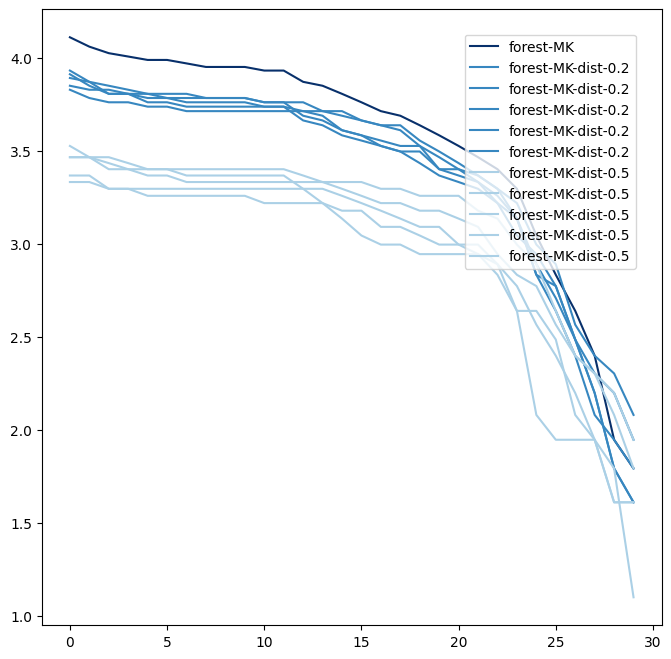

In [158]:
forestbci = bcis['forest-MK']
forestbci.transform(transformation='disturbance', fraction=0.5)
forestbci.run()
forestbci.plot_all(cmap="Blues_r")


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

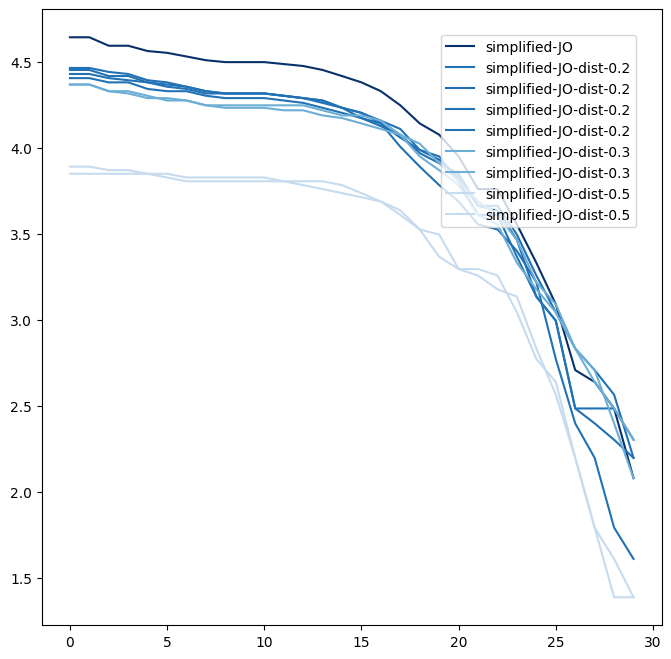

In [153]:
farmbci = bcis['simplified-JO']
farmbci.transform(transformation='disturbance', fraction=0.5)
farmbci.run()
farmbci.plot_all(cmap="Blues_r")
